In [6]:
!pip install keras-tcn
!pip install keras-tcn --no-dependencies

In [7]:
import math
import matplotlib.pyplot as plt
import numpy as np

import keras 
import pandas as pd


from keras.models import Sequential
from keras.layers import Dense 

from keras.layers import Dropout

from keras.layers import LSTM

from keras.layers import *


from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping


from keras.layers import Dense, InputLayer, Dropout, Flatten, BatchNormalization, Conv1D



from keras.layers import Dense, Embedding, LSTM, Bidirectional

from tcn import TCN, tcn_full_summary

DATA

In [8]:
df=pd.read_csv("AAPL.csv")
print("Number of rows and columns:", df.shape)
df.head(5)
training_set = df.iloc[:1052, 4:5].values

test_set = df.iloc[1052:, 4:5].values
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 1052):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0],  X_train.shape[1], 1, 1))
X_train.shape

Number of rows and columns: (1503, 7)


(992, 60, 1, 1)

TCN Model

In [9]:
dataset_train = df.iloc[:1052, 4:5]
dataset_test = df.iloc[1052:, 4:5]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
print(inputs.shape)
X_test = []
for i in range(60, 511):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

y =  dataset_test.values.reshape(451,) 
# (459, 60, 1)

(511, 1)
(451, 60, 1)


In [5]:
np.random.seed(1)
model = Sequential()
model.add(TCN(nb_filters=64, kernel_size=5, nb_stacks=1, dilations=[1, 2, 4, 8, 16 ], padding='causal', use_skip_connections=False, dropout_rate=0.1, return_sequences=False, activation='relu', input_shape = (X_train.shape[1], 1)))
#model.add(Dropout(0.1))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 50, batch_size = 32)

KeyboardInterrupt: ignored

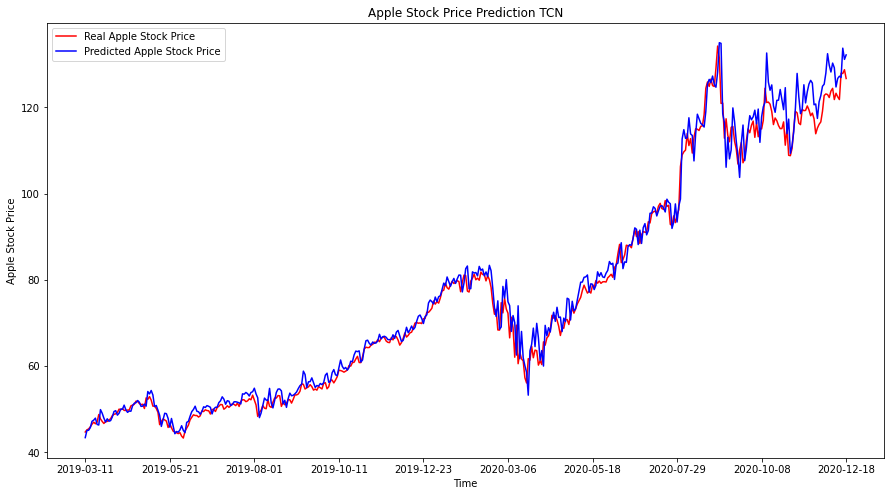

<Figure size 432x288 with 0 Axes>

In [ ]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real Apple Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted Apple Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('Apple Stock Price Prediction TCN')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show() 
plt.savefig("Apple TCN")

In [ ]:
abse = mean_absolute_error(predicted_stock_price,y)
abse

2.114110077225848

In [ ]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
rmse

3.1034186570451694

TCN + GRU model

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 60, 1)]      0                                            
__________________________________________________________________________________________________
gru_2 (GRU)                     (None, 200)          121800      input_3[0][0]                    
__________________________________________________________________________________________________
tcn_2 (TCN)                     (None, 64)           185408      input_3[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 1)            201         gru_2[0][0]                      
____________________________________________________________________________________________

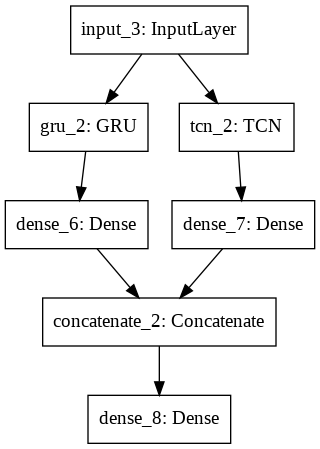

In [17]:
np.random.seed(1)


from keras.layers import Input
from keras.utils import plot_model
from keras.layers.merge import concatenate
from keras.models import Model

visible = Input(shape=(60,1))

#GRU
gru1 = GRU(units = 200, input_shape = (X_train.shape[1], 1))(visible)
out1 = Dense(units = 1)(gru1)

#TCN
tcn1 = TCN(nb_filters=64, kernel_size=5, nb_stacks=1, dilations=[1, 2, 4, 8, 16 ], padding='causal', use_skip_connections=False, dropout_rate=0, return_sequences=False, activation='relu', input_shape = (X_train.shape[1], 1))(visible)
out2 = Dense(units = 1)(tcn1)

# merge interpretation
merge = concatenate([out1, out2])

# output
output = Dense(1)(merge)
model = Model(inputs=visible, outputs=output)

# summarize layers
print(model.summary())

# plot graph
plot_model(model, to_file='shared_feature_extractor.png')

In [18]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
31/31 [==============================] - 3s 13ms/step - loss: 10.3796
Epoch 2/30
31/31 [==============================] - 0s 10ms/step - loss: 0.0179
Epoch 3/30
31/31 [==============================] - 0s 10ms/step - loss: 0.0063
Epoch 4/30
31/31 [==============================] - 0s 10ms/step - loss: 0.0042
Epoch 5/30
31/31 [==============================] - 0s 10ms/step - loss: 0.0032
Epoch 6/30
31/31 [==============================] - 0s 10ms/step - loss: 0.0070
Epoch 7/30
31/31 [==============================] - 0s 10ms/step - loss: 0.0026
Epoch 8/30
31/31 [==============================] - 0s 9ms/step - loss: 0.0029
Epoch 9/30
31/31 [==============================] - 0s 9ms/step - loss: 0.0058
Epoch 10/30
31/31 [==============================] - 0s 10ms/step - loss: 0.0084
Epoch 11/30
31/31 [==============================] - 0s 10ms/step - loss: 0.0033
Epoch 12/30
31/31 [==============================] - 0s 10ms/step - loss: 0.0033
Epoch 13/30
31/31 [===================

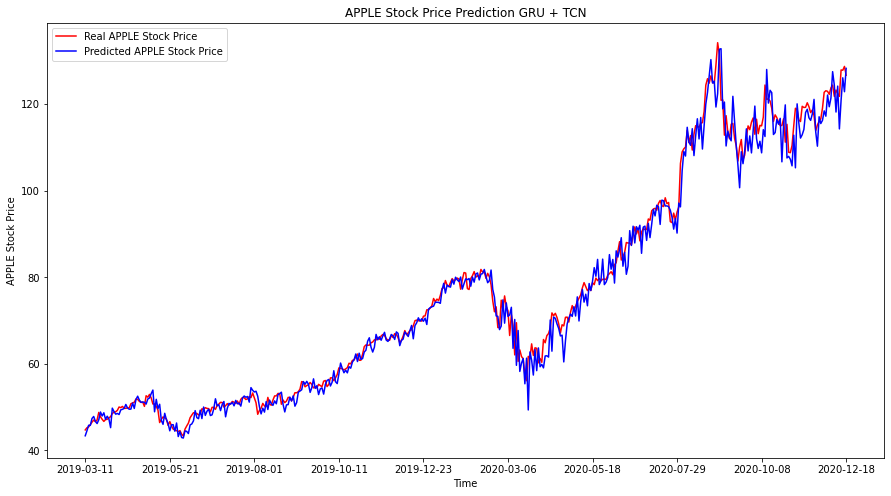

<Figure size 432x288 with 0 Axes>

In [19]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real APPLE Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted APPLE Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('APPLE Stock Price Prediction GRU + TCN')
plt.xlabel('Time')
plt.ylabel('APPLE Stock Price')
plt.legend()
plt.show() 
plt.savefig("APPLE GRU + TCN")

In [20]:
abse = mean_absolute_error(predicted_stock_price,y)
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
print(abse, rmse)

2.0422074579596337 3.0377280013913097


CNN LSTM MODEL

In [ ]:

dataset_train = df.iloc[:1052, 4:5]
dataset_test = df.iloc[1052:, 4:5]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
print(inputs.shape)
X_test = []
for i in range(60, 511):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1, 1))
print(X_test.shape)

y =  dataset_test.values.reshape(451,) 
# (459, 60, 1)

(511, 1)
(451, 60, 1, 1)


In [ ]:
np.random.seed(1)

model = Sequential()

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape = (X_train.shape[1],1, 1)))

model.add(TimeDistributed(MaxPooling1D(pool_size=1)))

model.add(TimeDistributed(Flatten()))

model.add(GRU(units = 700)) #, return_sequences = True

model.add(Dropout(0.1))


model.add(Dense(units = 1))


model.compile(optimizer = 'adam', loss = 'mean_squared_error')


model.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
31/31 [==============================] - 2s 15ms/step - loss: 0.0398
Epoch 2/50
31/31 [==============================] - 0s 12ms/step - loss: 7.0839e-04
Epoch 3/50
31/31 [==============================] - 0s 12ms/step - loss: 4.1419e-04
Epoch 4/50
31/31 [==============================] - 0s 12ms/step - loss: 3.7549e-04
Epoch 5/50
31/31 [==============================] - 0s 12ms/step - loss: 4.9301e-04
Epoch 6/50
31/31 [==============================] - 0s 12ms/step - loss: 4.0495e-04
Epoch 7/50
31/31 [==============================] - 0s 12ms/step - loss: 4.2568e-04
Epoch 8/50
31/31 [==============================] - 0s 12ms/step - loss: 3.9264e-04
Epoch 9/50
31/31 [==============================] - 0s 12ms/step - loss: 4.4315e-04
Epoch 10/50
31/31 [==============================] - 0s 12ms/step - loss: 4.3217e-04
Epoch 11/50
31/31 [==============================] - 0s 12ms/step - loss: 5.0849e-04
Epoch 12/50
31/31 [==============================] - 0s 12ms/step - loss: 3.83

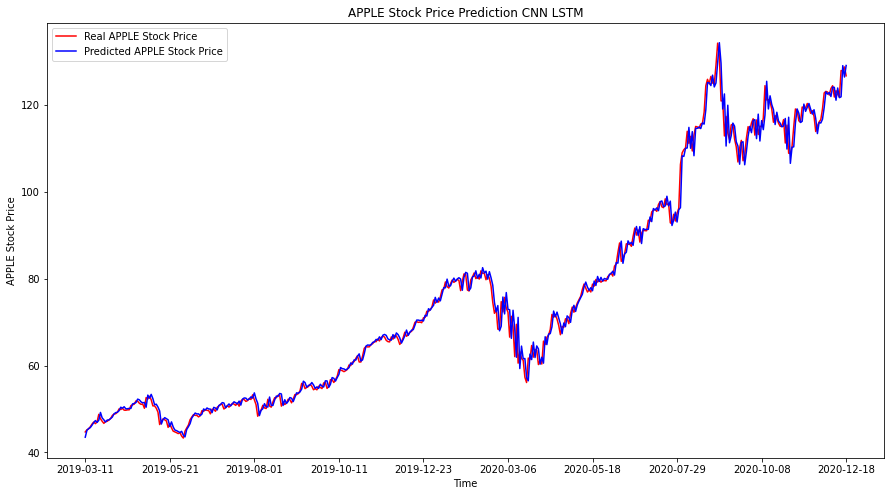

<Figure size 432x288 with 0 Axes>

In [ ]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real APPLE Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted APPLE Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('APPLE Stock Price Prediction CNN LSTM')
plt.xlabel('Time')
plt.ylabel('APPLE Stock Price')
plt.legend()
plt.show() 
plt.savefig("APPLE CNN LSTM")

In [ ]:
abse = mean_absolute_error(predicted_stock_price,y)
abse

1.3651878929197054

In [ ]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
rmse

2.1133872823766486

CNN

In [ ]:
df=pd.read_csv("AAPL.csv")
print("Number of rows and columns:", df.shape)
df.head(5)
training_set = df.iloc[:1052, 4:5].values

test_set = df.iloc[1052:, 4:5].values
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 1052):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1], 1))
X_train.shape

Number of rows and columns: (1503, 7)


(992, 1, 60, 1)

In [ ]:
np.random.seed(1)

model = Sequential()

model.add(TimeDistributed(Conv1D(filters=128, kernel_size=11, activation='relu'), input_shape = (1, X_train.shape[2],1)))
print(model.output_shape)
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
print(model.output_shape)
model.add(TimeDistributed(Flatten()))
print(model.output_shape)


model.add(Dense(units = 1))
print(model.output_shape)

model.compile(optimizer = 'adam', loss = 'mean_squared_error')


model.fit(X_train, y_train, epochs = 30, batch_size = 32)

(None, 1, 50, 128)
(None, 1, 25, 128)
(None, 1, 3200)
(None, 1, 1)
Epoch 1/30
31/31 [==============================] - 0s 2ms/step - loss: 0.0461
Epoch 2/30
31/31 [==============================] - 0s 1ms/step - loss: 0.0078
Epoch 3/30
31/31 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 4/30
31/31 [==============================] - 0s 2ms/step - loss: 0.0036
Epoch 5/30
31/31 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 6/30
31/31 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 7/30
31/31 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 8/30
31/31 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 9/30
31/31 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 10/30
31/31 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 11/30
31/31 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 12/30
31/31 [==============================] - 0s 1ms/st

In [ ]:

dataset_train = df.iloc[:1052, 4:5]
dataset_test = df.iloc[1052:, 4:5]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
print(inputs.shape)
X_test = []
for i in range(60, 511):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1],1))
print(X_test.shape)
# (459, 60, 1)

(511, 1)
(451, 1, 60, 1)


In [ ]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = predicted_stock_price.reshape(451,1)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

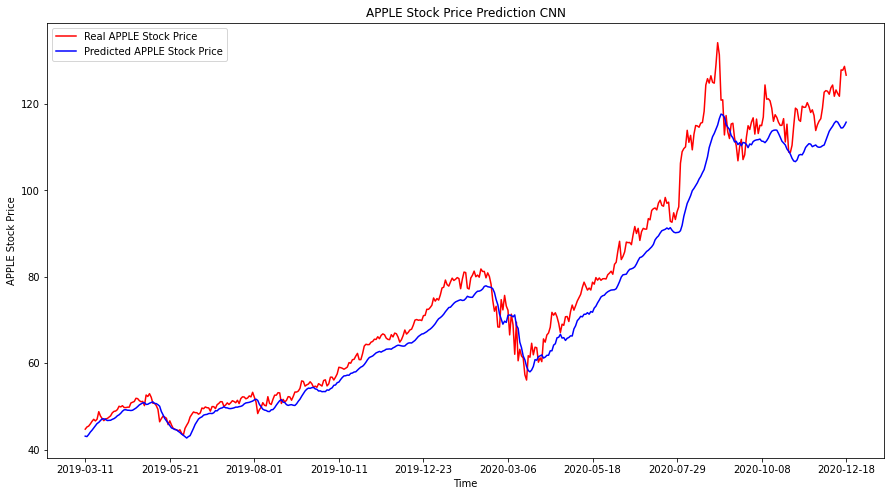

<Figure size 432x288 with 0 Axes>

In [ ]:

predicted_stock_price = model.predict(X_test).reshape(-1,1)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real APPLE Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted APPLE Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('APPLE Stock Price Prediction CNN')
plt.xlabel('Time')
plt.ylabel('APPLE Stock Price')
plt.legend()
plt.show() 
plt.savefig("APPLE CNN")

In [ ]:
abse = mean_absolute_error(predicted_stock_price,y)
abse

4.185498110420853

In [ ]:
rmse=math.sqrt(mean_squared_error(predicted_stock_price,y))
rmse

5.53012740429876

LSTM GRU MODEL

In [ ]:

# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 1052):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0],  X_train.shape[1], 1))
X_train.shape

(992, 60, 1)

In [ ]:
np.random.seed(1)
model = Sequential()
model.add(LSTM(units = 700, return_sequences=True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.1))
model.add(GRU(units = 700,  input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.1))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
31/31 [==============================] - 3s 30ms/step - loss: 0.0320
Epoch 2/30
31/31 [==============================] - 1s 28ms/step - loss: 9.5834e-04
Epoch 3/30
31/31 [==============================] - 1s 28ms/step - loss: 6.5889e-04
Epoch 4/30
31/31 [==============================] - 1s 28ms/step - loss: 6.0565e-04
Epoch 5/30
31/31 [==============================] - 1s 28ms/step - loss: 5.4997e-04
Epoch 6/30
31/31 [==============================] - 1s 28ms/step - loss: 6.5068e-04
Epoch 7/30
31/31 [==============================] - 1s 28ms/step - loss: 5.0434e-04
Epoch 8/30
31/31 [==============================] - 1s 28ms/step - loss: 5.6824e-04
Epoch 9/30
31/31 [==============================] - 1s 28ms/step - loss: 8.1218e-04
Epoch 10/30
31/31 [==============================] - 1s 28ms/step - loss: 6.3221e-04
Epoch 11/30
31/31 [==============================] - 1s 28ms/step - loss: 6.0283e-04
Epoch 12/30
31/31 [==============================] - 1s 28ms/step - loss: 5.16

TEST DATA

In [ ]:
# Getting the predicted stock price of 2017
dataset_train = df.iloc[:1052, 4:5]
dataset_test = df.iloc[1052:, 4:5]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
print(inputs.shape)
X_test = []
for i in range(60, 511):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)


(511, 1)
(451, 60, 1)


PREDICTION

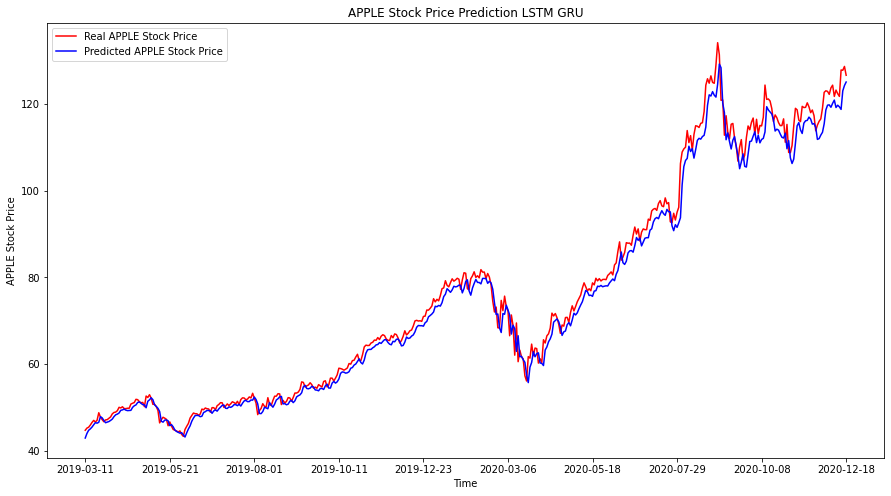

<Figure size 432x288 with 0 Axes>

In [ ]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real APPLE Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted APPLE Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('APPLE Stock Price Prediction LSTM GRU')
plt.xlabel('Time')
plt.ylabel('APPLE Stock Price')
plt.legend()
plt.show() 
plt.savefig("APPLE LSTM GRU")

In [ ]:
abse = mean_absolute_error(predicted_stock_price,y)
abse

2.0102155908116512

In [ ]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
rmse

2.72938876799123

LSTM Model

In [ ]:
model = Sequential()

model.add(LSTM(units = 700, input_shape = (X_train.shape[1], 1))) 
model.add(Dropout(0.1))

model.add(Dense(units = 1))


model.compile(optimizer = 'adam', loss = 'mean_squared_error')


model.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
31/31 [==============================] - 2s 16ms/step - loss: 0.0507
Epoch 2/30
31/31 [==============================] - 0s 13ms/step - loss: 0.0014
Epoch 3/30
31/31 [==============================] - 0s 13ms/step - loss: 0.0010
Epoch 4/30
31/31 [==============================] - 0s 13ms/step - loss: 9.2957e-04
Epoch 5/30
31/31 [==============================] - 0s 13ms/step - loss: 9.0964e-04
Epoch 6/30
31/31 [==============================] - 0s 13ms/step - loss: 9.2925e-04
Epoch 7/30
31/31 [==============================] - 0s 13ms/step - loss: 9.6312e-04
Epoch 8/30
31/31 [==============================] - 0s 13ms/step - loss: 8.4752e-04
Epoch 9/30
31/31 [==============================] - 0s 13ms/step - loss: 8.4840e-04
Epoch 10/30
31/31 [==============================] - 0s 13ms/step - loss: 0.0011
Epoch 11/30
31/31 [==============================] - 0s 13ms/step - loss: 9.3755e-04
Epoch 12/30
31/31 [==============================] - 0s 13ms/step - loss: 7.4227e-04
Epoch

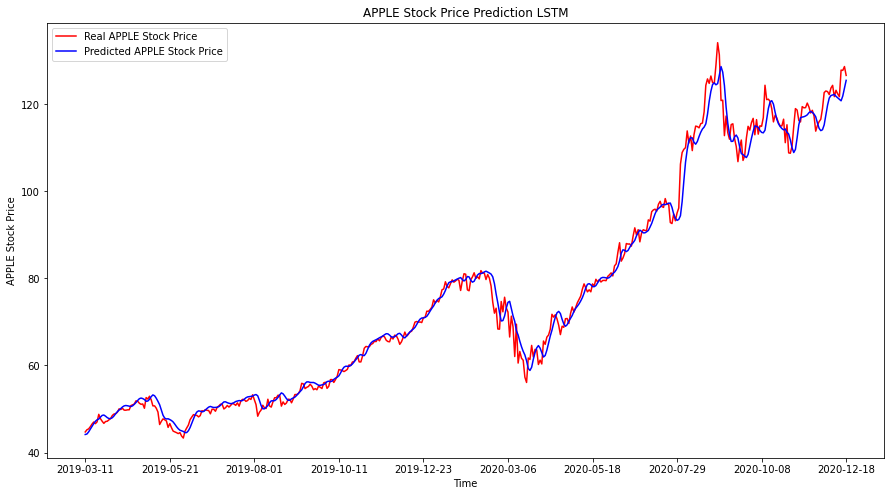

<Figure size 432x288 with 0 Axes>

In [ ]:
 predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real APPLE Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted APPLE Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('APPLE Stock Price Prediction LSTM')
plt.xlabel('Time')
plt.ylabel('APPLE Stock Price')
plt.legend()
plt.show() 
plt.savefig("APPLE LSTM")

In [ ]:
abse = mean_absolute_error(predicted_stock_price,y)
abse

1.6538938584325416

In [ ]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
rmse

2.541630119013605

RNN MODEL


In [ ]:
model = Sequential()

model.add(SimpleRNN(units = 700, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(X_train, y_train, epochs = 30, batch_size = 32) 

Epoch 1/30
31/31 [==============================] - 2s 35ms/step - loss: 0.7237
Epoch 2/30
31/31 [==============================] - 1s 33ms/step - loss: 0.1604
Epoch 3/30
31/31 [==============================] - 1s 38ms/step - loss: 0.1480
Epoch 4/30
31/31 [==============================] - 1s 36ms/step - loss: 0.0837
Epoch 5/30
31/31 [==============================] - 1s 34ms/step - loss: 0.0686
Epoch 6/30
31/31 [==============================] - 1s 37ms/step - loss: 0.0382
Epoch 7/30
31/31 [==============================] - 1s 37ms/step - loss: 0.0218
Epoch 8/30
31/31 [==============================] - 1s 36ms/step - loss: 0.0077
Epoch 9/30
31/31 [==============================] - 1s 37ms/step - loss: 0.0025
Epoch 10/30
31/31 [==============================] - 1s 36ms/step - loss: 0.0022
Epoch 11/30
31/31 [==============================] - 1s 36ms/step - loss: 0.0015
Epoch 12/30
31/31 [==============================] - 1s 31ms/step - loss: 0.0014
Epoch 13/30
31/31 [==================

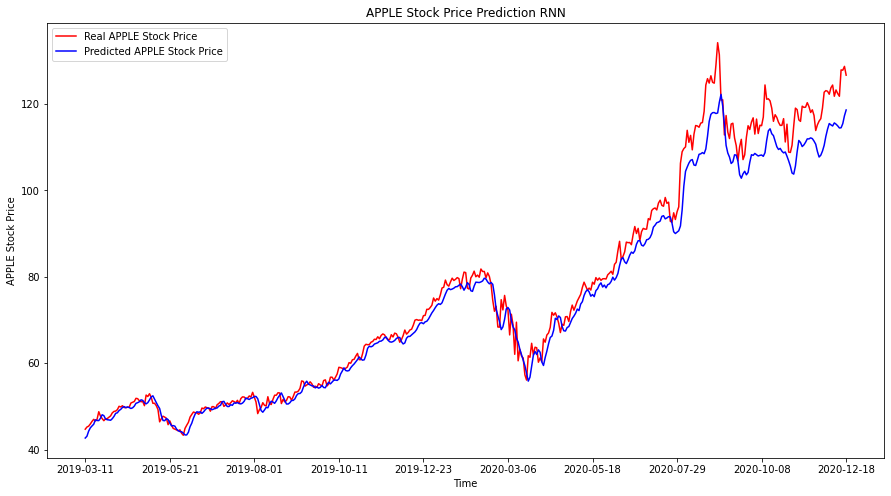

<Figure size 432x288 with 0 Axes>

In [ ]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real APPLE Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted APPLE Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('APPLE Stock Price Prediction RNN')
plt.xlabel('Time')
plt.ylabel('APPLE Stock Price')
plt.legend()
plt.show() 
plt.savefig("APPLE RNN")

In [ ]:
abse = mean_absolute_error(predicted_stock_price,y)
abse

2.938930774684728

In [ ]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
rmse

4.292592553074991

GRU

In [ ]:
np.random.seed(1)

model = Sequential()

model.add(GRU(units = 700, input_shape = (X_train.shape[1], 1))) 

model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')


model.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
31/31 [==============================] - 2s 12ms/step - loss: 0.0394
Epoch 2/30
31/31 [==============================] - 0s 12ms/step - loss: 0.0012
Epoch 3/30
31/31 [==============================] - 0s 12ms/step - loss: 7.0989e-04
Epoch 4/30
31/31 [==============================] - 0s 12ms/step - loss: 6.3211e-04
Epoch 5/30
31/31 [==============================] - 0s 12ms/step - loss: 7.1458e-04
Epoch 6/30
31/31 [==============================] - 0s 12ms/step - loss: 8.3607e-04
Epoch 7/30
31/31 [==============================] - 0s 12ms/step - loss: 7.5431e-04
Epoch 8/30
31/31 [==============================] - 0s 12ms/step - loss: 6.8648e-04
Epoch 9/30
31/31 [==============================] - 0s 12ms/step - loss: 5.8856e-04
Epoch 10/30
31/31 [==============================] - 0s 12ms/step - loss: 7.0407e-04
Epoch 11/30
31/31 [==============================] - 0s 12ms/step - loss: 6.9382e-04
Epoch 12/30
31/31 [==============================] - 0s 12ms/step - loss: 6.8574e-

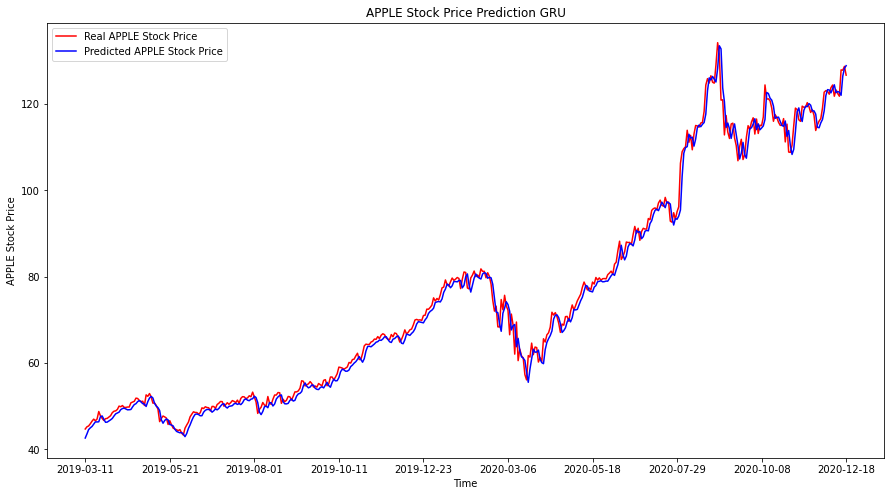

<Figure size 432x288 with 0 Axes>

In [ ]:

predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real APPLE Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted APPLE Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('APPLE Stock Price Prediction GRU')
plt.xlabel('Time')
plt.ylabel('APPLE Stock Price')
plt.legend()
plt.show() 
plt.savefig("APPLE GRU")

In [ ]:
abse = mean_absolute_error(predicted_stock_price,y)
abse

1.4964641874215066

In [ ]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
rmse

2.1090591769219813

Bi-LSTM

In [ ]:
np.random.seed(1)
model = Sequential()

model.add(Bidirectional(LSTM(units = 700, input_shape = (X_train.shape[1], 1)))) 
model.add(Dropout(0.1))

model.add(Dense(units = 1))


model.compile(optimizer = 'adam', loss = 'mean_squared_error')


model.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
31/31 [==============================] - 5s 30ms/step - loss: 0.0549
Epoch 2/30
31/31 [==============================] - 1s 29ms/step - loss: 0.0051
Epoch 3/30
31/31 [==============================] - 1s 29ms/step - loss: 0.0025
Epoch 4/30
31/31 [==============================] - 1s 29ms/step - loss: 0.0014
Epoch 5/30
31/31 [==============================] - 1s 29ms/step - loss: 0.0012
Epoch 6/30
31/31 [==============================] - 1s 29ms/step - loss: 0.0012
Epoch 7/30
31/31 [==============================] - 1s 29ms/step - loss: 0.0015
Epoch 8/30
31/31 [==============================] - 1s 29ms/step - loss: 0.0013
Epoch 9/30
31/31 [==============================] - 1s 29ms/step - loss: 8.5182e-04
Epoch 10/30
31/31 [==============================] - 1s 29ms/step - loss: 0.0011
Epoch 11/30
31/31 [==============================] - 1s 29ms/step - loss: 8.3191e-04
Epoch 12/30
31/31 [==============================] - 1s 29ms/step - loss: 0.0010
Epoch 13/30
31/31 [==========

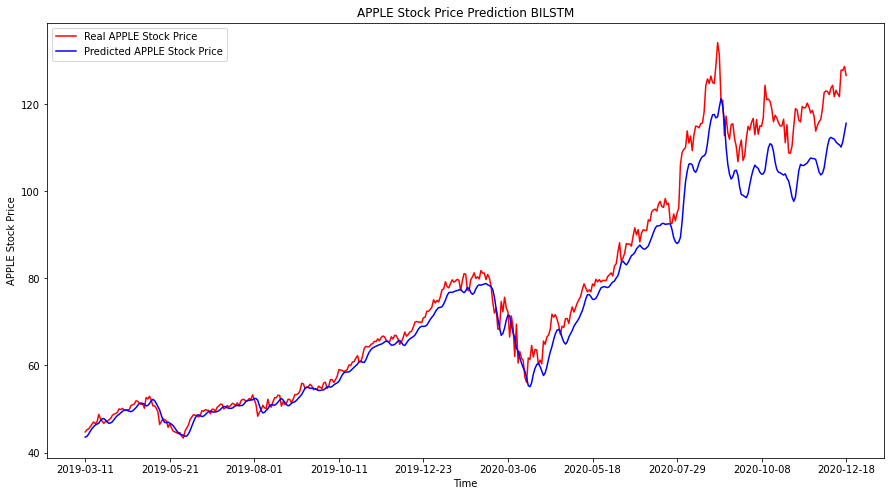

<Figure size 432x288 with 0 Axes>

In [ ]:

predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real APPLE Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted APPLE Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('APPLE Stock Price Prediction BILSTM')
plt.xlabel('Time')
plt.ylabel('APPLE Stock Price')
plt.legend()
plt.show() 
plt.savefig("APPLE BILSTM")

In [ ]:
abse = mean_absolute_error(predicted_stock_price,y)
abse

3.9538632592795078

In [ ]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
rmse

5.866052116602904

Bi-GRU

In [ ]:
model = Sequential()

model.add(Bidirectional(GRU(units = 700, input_shape = (X_train.shape[1], 1))))
model.add(Dropout(0.1))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')


model.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
31/31 [==============================] - 5s 106ms/step - loss: 0.0429
Epoch 2/30
31/31 [==============================] - 3s 110ms/step - loss: 0.0025
Epoch 3/30
31/31 [==============================] - 3s 106ms/step - loss: 0.0011
Epoch 4/30
31/31 [==============================] - 3s 104ms/step - loss: 7.4574e-04
Epoch 5/30
31/31 [==============================] - 3s 109ms/step - loss: 6.0459e-04
Epoch 6/30
31/31 [==============================] - 3s 108ms/step - loss: 5.7435e-04
Epoch 7/30
31/31 [==============================] - 3s 105ms/step - loss: 5.7435e-04
Epoch 8/30
31/31 [==============================] - 3s 107ms/step - loss: 7.2886e-04
Epoch 9/30
31/31 [==============================] - 3s 107ms/step - loss: 5.9896e-04
Epoch 10/30
31/31 [==============================] - 3s 103ms/step - loss: 5.9738e-04
Epoch 11/30
31/31 [==============================] - 3s 106ms/step - loss: 5.5264e-04
Epoch 12/30
31/31 [==============================] - 3s 104ms/step - loss: 

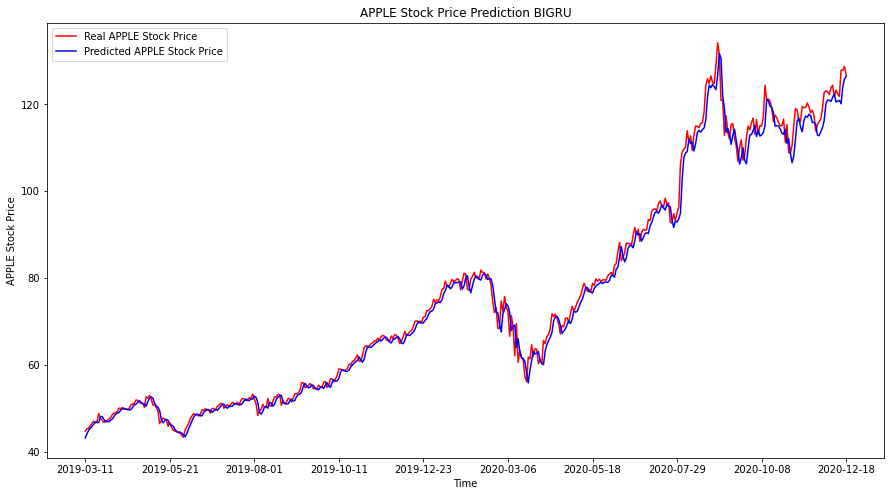

<Figure size 432x288 with 0 Axes>

In [ ]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
y =  dataset_test.values.reshape(451,) 
x = df.loc[1052: , "Date"] 
# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y, c= "red", label = "Real APPLE Stock Price")
plt.plot(df.loc[1052:, "Date"],predicted_stock_price, color = "blue", label = "Predicted APPLE Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('APPLE Stock Price Prediction BIGRU')
plt.xlabel('Time')
plt.ylabel('APPLE Stock Price')
plt.legend()
plt.show() 
plt.savefig("APPLE BIGRU")

In [ ]:
abse = mean_absolute_error(predicted_stock_price,y)
abse

1.528899847362307

In [ ]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y))
rmse

2.239908490860149

Breaking Dataset to Improve Performance

In [ ]:
training_set = df.iloc[:, 4:5].values
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output




In [ ]:
X_train = []
y_train = []
for i in range(60, 351):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])

for i in range(501, 852):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])

for i in range(1002, 1353):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0],  X_train.shape[1], 1))
X_train.shape

(993, 60, 1)

In [ ]:

inputs = df.iloc[:, 4:5].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
print(inputs.shape)




(1503, 1)


In [ ]:
X_test = []
y_test = []
for i in range(351, 501):
    X_test.append(inputs[i-60:i, 0])
    y_test.append(df.iloc[i, 4:5].values)

for i in range(852, 1002):
    X_test.append(inputs[i-60:i, 0])
    y_test.append(df.iloc[i, 4:5].values)

for i in range(1353, 1503):
    X_test.append(inputs[i-60:i, 0])
    y_test.append(df.iloc[i, 4:5].values)

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)
# (459, 60, 1)

(450, 60, 1)


In [ ]:
np.random.seed(1)

model = Sequential()

model.add(GRU(units = 700, input_shape = (X_train.shape[1], 1))) 

model.add(Dropout(0.2))

model.add(Dense(units = 1))


model.compile(optimizer = 'adam', loss = 'mean_squared_error')


model.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
32/32 [==============================] - 2s 13ms/step - loss: 0.0092
Epoch 2/30
32/32 [==============================] - 0s 13ms/step - loss: 2.1259e-04
Epoch 3/30
32/32 [==============================] - 0s 13ms/step - loss: 1.6629e-04
Epoch 4/30
32/32 [==============================] - 0s 13ms/step - loss: 1.4275e-04
Epoch 5/30
32/32 [==============================] - 0s 12ms/step - loss: 1.5509e-04
Epoch 6/30
32/32 [==============================] - 0s 13ms/step - loss: 1.6224e-04
Epoch 7/30
32/32 [==============================] - 0s 13ms/step - loss: 1.5613e-04
Epoch 8/30
32/32 [==============================] - 0s 13ms/step - loss: 1.3217e-04
Epoch 9/30
32/32 [==============================] - 1s 19ms/step - loss: 1.6635e-04
Epoch 10/30
32/32 [==============================] - 0s 13ms/step - loss: 1.6176e-04
Epoch 11/30
32/32 [==============================] - 0s 12ms/step - loss: 1.3454e-04
Epoch 12/30
32/32 [==============================] - 0s 13ms/step - loss: 2.08

In [ ]:

predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


In [ ]:
abse = mean_absolute_error(predicted_stock_price, y_test)

In [ ]:
abse

1.329441102915039

In [ ]:
rmse = math.sqrt(mean_squared_error(predicted_stock_price,y_test))
rmse

2.007919973903279

In [ ]:
x1 = df.loc[351:500 , "Date"]
x2 = df.loc[852:1001 , "Date"]
x3 = df.loc[1353: , "Date"]

In [ ]:
x = pd.concat([x1,x2,x3], axis =0)

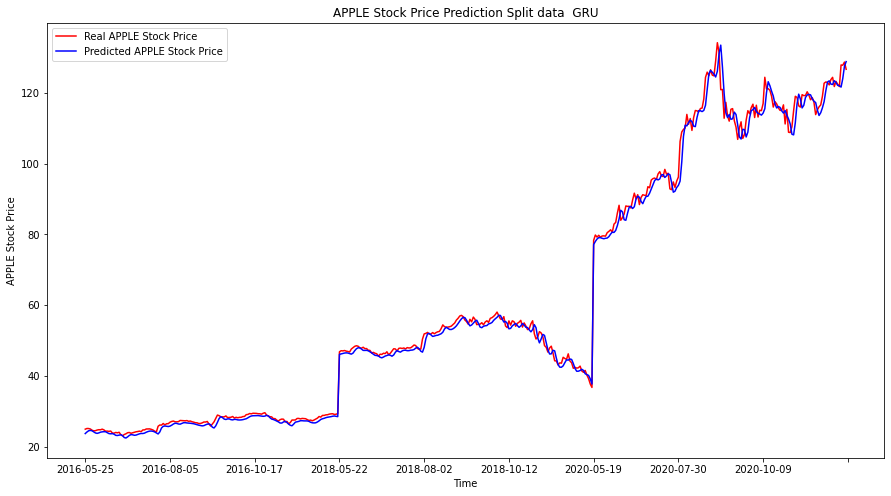

<Figure size 432x288 with 0 Axes>

In [ ]:

# Visualising the results
plt.figure(figsize=(15,8))
plt.plot(x, y_test, c= "red", label = "Real APPLE Stock Price")
plt.plot(x,predicted_stock_price, color = "blue", label = "Predicted APPLE Stock Price")
plt.xticks(np.arange(0,451,50))
plt.title('APPLE Stock Price Prediction Split data  GRU')
plt.xlabel('Time')
plt.ylabel('APPLE Stock Price')
plt.legend()
plt.show() 
plt.savefig("APPLE Split data GRU")